In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=9df8c6b824dbde8218f258fbce9ea9f142ad0668bf4a3adeae495ba535f21674
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=80c364ec1528fb9d96cf3444d7a74ecf23707b380522c7860feda3989e21817d
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=359e7c6721de3a226fe51bd96abf8a1249301e24c65c88dd5d62e52e601d82ec
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [2]:
import os
import bert

from tensorflow import keras

model_name = "chinese_L-12_H-768_A-12"
model_dir = bert.fetch_google_bert_model(model_name, ".models")
model_ckpt = os.path.join(model_dir, "bert_model.ckpt")

bert_params = bert.params_from_pretrained_ckpt(model_dir)
l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

chinese_L-12_H-768_A-12.zip: 382MB [00:06, 54.9MB/s]                           


extracting to: .models/chinese_L-12_H-768_A-12


In [3]:
!pip3 install transformers==4.4.1

     |████████████████████████████████| 2.1MB 13.4MB/s 
     |████████████████████████████████| 901kB 60.1MB/s 
     |████████████████████████████████| 3.3MB 46.6MB/s 


In [4]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=True)

In [5]:
import pandas as pd
data = pd.read_csv("data/label_revise.csv", encoding='utf_8_sig')
print(data)

                                                   text  label
0     Wind风控日报数据显示，据经济观察网，在2020年，共有4家上市股份行的利润实现负增长，为...     -1
1     澳门4月份幸运博彩毛收入84.01亿澳元，同比增长1014.4%；1-4月份幸运博彩毛收入3...      1
2                              反垄断风暴袭来！9张罚单落下，腾讯等多家企业被罚     -1
3                                     券商五月金股名单出炉，后市怎么走？      0
4                             巴菲特2021年股东大会前瞻：疫情下的那些变与不变      0
...                                                 ...    ...
1364                                        蓝色光标:2个亏损公司     -1
1365                                      蓝色光标:明天又要跌停了。     -1
1366                                      蓝色光标:明天大跌甚至跌停     -1
1367                                             明天继续跌停     -1
1368                                             明天跌停开盘     -1

[1369 rows x 2 columns]


In [6]:
from sklearn.model_selection import train_test_split
validation_percent = 0.20
train_x, validate_x, train_y, validate_y = train_test_split(data["text"].values, data["label"].values, test_size=validation_percent)

In [7]:
train_y

array([-1,  0,  0, ...,  1, -1, -1])

In [8]:
sequence_length = 256

# Train
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

In [9]:
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [10]:
import tensorflow as tf

In [11]:
from tensorflow.keras.utils import to_categorical

batch_size = 16
num_classes = 3
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

label2index = {-1: 0, 0: 1, 1: 2}
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='int32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='int32')

train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_processed_y))

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>
validation_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None, 3)), types: ((tf.int32, tf.int32, tf.int32), tf.int32)>


In [13]:
model1 = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model1.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  102267648 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 102,269,955
Trainable params: 102,269,955
Non-trainable params: 0
_________________________________________________________________


In [15]:
import time
from tensorflow.python.keras import backend as K
K.clear_session()

learning_rate = 2e-5
epochs = 30

optimizer = keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model1.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model

start_time = time.time()
training_results = model1.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

Motivated by FinBERT package, when we train Chinese BERT models, we also get predictions which are represented in three different columns:

1) logit: probabilities for each class

2) prediction: predicted label

3) sentiment_score: sentiment score calculated as: probability of positive - probability of negative

In [16]:
import numpy as np

def get_prediction(model, data):
    y_pred_bert = model.predict(data)
    logits = tf.nn.softmax(y_pred_bert["logits"])
    y_preds = np.argmax(y_pred_bert['logits'], axis=1)
    y_preds[np.where(y_preds == 0)] = -1
    y_preds[np.where(y_preds == 1)] = 0
    y_preds[np.where(y_preds == 2)] = 1
    senti_score = logits[:, 2] - logits[:, 0]

    return logits, y_preds, senti_score

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import json
from tensorflow.python.keras.utils.layer_utils import count_params

def save_model(model, path="models",model_name="model01"):

    # Ensure path exists
    if not os.path.exists(path):
        os.mkdir(path)

    if isinstance(model,TFBertForSequenceClassification):
      #model.save_pretrained(path)
      model.save_weights(os.path.join(path,model_name+".h5"))
    else:
      # Save the enitire model (structure + weights)
      model.save(os.path.join(path,model_name+".hdf5"))

      # Save only the weights
      model.save_weights(os.path.join(path,model_name+".h5"))

      # Save the structure only
      model_json = model.to_json()
      with open(os.path.join(path,model_name+".json"), "w") as json_file:
          json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".h5")).st_size
    return model_size

class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, epochs,save=True):
    
    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(20,5))
    axs = fig.add_subplot(1,3,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()
    
    axs = fig.add_subplot(1,3,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()
    
    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print(evaluation_results)
    
    if save:
        # Save model
        save_model(model, model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = count_params(model.trainable_weights)
        non_trainable_parameters = count_params(model.non_trainable_weights)

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "epochs":epochs,
            "name": model.name,
            "id": int(time.time())
        }
        with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
            json_file.write(json.dumps(metrics,cls=JsonEncoder))

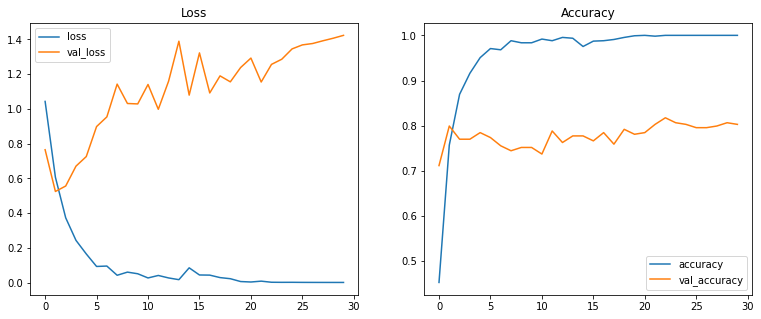

18/18 [==============================] - 2s 99ms/step - loss: 1.4231 - accuracy: 0.8029
[1.4231419563293457, 0.8029196858406067]


In [18]:
evaluate_save_model(model1, validation_data, training_results, execution_time, learning_rate, epochs)

In [19]:
data_test = pd.read_csv("data/sentense_full.csv", encoding='utf_8_sig')
print(data_test)

                                                   text              file_name
0         华西证券股份有限公司研究报告转发给他人pHUAXI SECURITIES CO, LTD,  000671-20201109-0.txt
1     公司修正2020年度业绩预告,四季度业结畋超预期■事件:2021年1月29日,公司发布202...  002044-20210131-0.txt
2                               ■业绩预期变动主要由投资收益和计提减值准备所致  002044-20210131-0.txt
3     公司本次修改2020年业绩预告的主要原因在于投资收益和计提减值准备造成的影响:(1)2020...  002044-20210131-0.txt
4     公司主营业务为健康体检服务,2020年上半年受新冠疫情影响冲击较大,下半年随着疫情得到较好控...  002044-20210131-0.txt
...                                                 ...                    ...
7840              预计19-21年高端白酒消费量CAGR约10%,高端白酒均价CAGR约5%  000858-20191231-0.txt
7841                                 发展势能增强,蓄力集团“后干亿”时代  000858-20191231-0.txt
7842  19年作为营销改革年,全面导入控盘分利模式,利用数字化赋能推动转型,从高层架构到渠道人员都进...  000858-20191231-0.txt
7843  我们认为公司已由过去的“增量改革”开始转变为“存量改革”,持续升级的改革措施将大大强化公司发...  000858-20191231-0.txt
7844  我们认为19年公司营销改革成效显著,叠加产品更新升级、管理效率提升效应和数字化赋能转型,预计...  000858-20191231-0.txt

[7845 rows x 2 columns]


In [20]:
test_x = data_test["text"].values
test_x_processed = tokenizer.batch_encode_plus(
        test_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

In [21]:
test_data = tf.data.Dataset.from_tensor_slices((test_x_processed["input_ids"],
                                                  test_x_processed["token_type_ids"],
                                                  test_x_processed["attention_mask"]))
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [22]:
logits_validate, y_preds_validate, senti_validate = get_prediction(model1, test_data)

In [23]:
df_results = data_test.copy()
df_results["logit"] = list(logits_validate.numpy())
df_results["prediction"] = y_preds_validate
df_results["sentiment_score"] = senti_validate

In [24]:
df_results.head(10)

,text,file_name,logit,prediction,sentiment_score
0,"华西证券股份有限公司研究报告转发给他人pHUAXI SECURITIES CO, LTD,",000671-20201109-0.txt,"[0.004584774, 0.99411523, 0.0012999364]",0,-0.003285
1,"公司修正2020年度业绩预告,四季度业结畋超预期■事件:2021年1月29日,公司发布202...",002044-20210131-0.txt,"[0.00013832311, 0.0007638273, 0.9990978]",1,0.998959
2,■业绩预期变动主要由投资收益和计提减值准备所致,002044-20210131-0.txt,"[0.0018250061, 0.9976667, 0.0005082852]",0,-0.001317
3,公司本次修改2020年业绩预告的主要原因在于投资收益和计提减值准备造成的影响:(1)2020...,002044-20210131-0.txt,"[0.9286828, 0.070356086, 0.00096103543]",-1,-0.927722
4,"公司主营业务为健康体检服务,2020年上半年受新冠疫情影响冲击较大,下半年随着疫情得到较好控...",002044-20210131-0.txt,"[0.057634704, 0.8084528, 0.13391249]",0,0.076278
5,"如果剔除投资收益和减值准备带来的业绩影响,预计公司2020年全年仍可实现扭亏为盈",002044-20210131-0.txt,"[0.00056416757, 0.6518096, 0.3476262]",0,0.347062
6,"考虑到公司2020年前三季度累计实现营业收入44.19亿元,累计实现归母净亏损5.17亿元,...",002044-20210131-0.txt,"[0.0029743074, 0.20482609, 0.7921996]",1,0.789225
7,"“自建+并购”的发展模式帮助公司在短时间内实现全国布局,同时也带来了巨大的管理压力2018年...",002044-20210131-0.txt,"[0.99707174, 0.0024381592, 0.00049001613]",-1,-0.996582
8,"2019年公司牵手阿里以来,管理层发生数次重大变更,阿里系高管的入驻有望协助公司改善内部治理...",002044-20210131-0.txt,"[9.564509e-05, 0.0004483332, 0.999456]",1,0.999360
9,"我们认为,公司管理提升的效果已经初步显现,有望走出过去3年的低谷期,2021年或将成为新征程",002044-20210131-0.txt,"[0.00010666599, 0.0011523892, 0.998741]",1,0.998634


In [25]:
senti_df = df_results[["file_name", "sentiment_score"]].groupby(["file_name"]).mean()
senti_df = senti_df.reset_index()

In [26]:
senti_df.head(10)

,file_name,sentiment_score
0,000001-20111051-0.txt,0.304340
1,000001-20160309-0.txt,0.553912
2,000001-20160421-0.txt,0.321736
3,000001-20190428-0.txt,0.649150
4,000001-20200828-0.txt,0.099700
5,000001-20201026-0.txt,0.215459
6,000001-20210129-0.txt,0.369750
7,000001-20210201-0.txt,0.275722
8,000001-20210202-0.txt,0.006233
9,000002-20111129-0.txt,-0.050356


In [27]:
df_results.to_csv("data/result_Chinese_bert.csv", encoding='utf_8_sig')

In [28]:
senti_df.to_csv("data/senti_Chinese_bert.csv")

In [29]:
senti_df_finbert = pd.read_csv("data/sentiment_finbert_full_final.csv")
senti_df_finbert = senti_df_finbert[["file_name", "sentiment_score"]].groupby(["file_name"]).mean()
senti_df_finbert = senti_df_finbert.reset_index()

In [30]:
senti_df_finbert.shape

(609, 2)

In [31]:
senti_df.shape

(632, 2)

In [32]:
senti_df = senti_df.set_index("file_name")
senti_df = senti_df.reindex(senti_df_finbert["file_name"].values)
senti_df["sentiment_score_finbert"] = senti_df_finbert["sentiment_score"].values

In [33]:
senti_df

,sentiment_score,sentiment_score_finbert
file_name,,
000001-20111051-0.txt,0.304340,0.013028
000001-20160309-0.txt,0.553912,0.726259
000001-20160421-0.txt,0.321736,0.896930
000001-20190428-0.txt,0.649150,0.917128
000001-20200828-0.txt,0.099700,0.889456
...,...,...
603858-20170426-0.txt,0.383196,0.911597
603858-20190428-0.txt,0.438413,0.126759
603993-20201029-0.txt,0.439939,0.436567


Text(0, 0.5, 'Sentiment Score from Chinese Finetuned BERT')

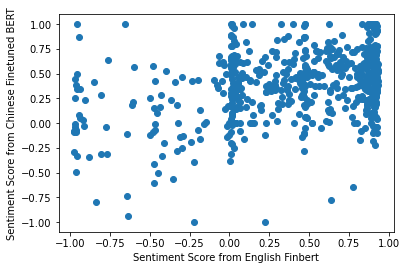

In [34]:
plt.scatter(senti_df["sentiment_score_finbert"], senti_df["sentiment_score"])
plt.xlabel("Sentiment Score from English Finbert")
plt.ylabel("Sentiment Score from Chinese Finetuned BERT")

In [35]:
import numpy.ma as ma
a = ma.masked_invalid(senti_df["sentiment_score_finbert"].values)
b = ma.masked_invalid(senti_df["sentiment_score"].values)

msk = (~a.mask & ~b.mask)
np.corrcoef(senti_df["sentiment_score_finbert"].values[msk], senti_df["sentiment_score"].values[msk])

array([[1.        , 0.36978563],
       [0.36978563, 1.        ]])

In [36]:
models_store_path = "models"
from glob import glob

models_metrics_list = glob(models_store_path+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

# Filter columns
view_metrics = view_metrics[["trainable_parameters","loss",
                             "accuracy","learning_rate","epochs","name", "model_size",]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,loss,accuracy,learning_rate,epochs,name,model_size
0,"102,269,955",1.42,80.29%,0.00002,30,tf_bert_for_sequence_classification,409 MB
